In [24]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection


In [25]:
save_dir=f"{exps_dir}/exp3/exp_gan"
if os.path.exists(save_dir) == False:
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [26]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['BoxCox_CLAIM_AMOUNT',
  'BoxCox_PREMIUM_AMOUNT',
  'Cubed_PREMIUM_AMOUNT',
  'EMPLOYMENT_STATUS',
  'PREMIUM_AMOUNT',
  'Quantile_CLAIM_AMOUNT',
  'Quantile_PREMIUM_AMOUNT',
  'Sqrt_CLAIM_AMOUNT',
  'Squared_PREMIUM_AMOUNT',
  'YeoJohnson_PREMIUM_AMOUNT'],
 'LDA': ['BoxCox_CLAIM_AMOUNT',
  'BoxCox_PREMIUM_AMOUNT',
  'Cubed_PREMIUM_AMOUNT',
  'EMPLOYMENT_STATUS',
  'PREMIUM_AMOUNT',
  'Quantile_CLAIM_AMOUNT',
  'Quantile_PREMIUM_AMOUNT',
  'Sqrt_CLAIM_AMOUNT',
  'Squared_PREMIUM_AMOUNT',
  'YeoJohnson_PREMIUM_AMOUNT'],
 'DTC': ['ADDRESS_LINE1',
  'AGE',
  'CUSTOMER_NAME',
  'INCIDENT_CITY',
  'INCIDENT_HOUR_OF_THE_DAY',
  'POLICY_NUMBER',
  'POSTAL_CODE',
  'PREMIUM_AMOUNT',
  'ROUTING_NUMBER',
  'YeoJohnson_CLAIM_AMOUNT'],
 'RD': ['BoxCox_CLAIM_AMOUNT',
  'CUSTOMER_NAME',
  'Cubed_PREMIUM_AMOUNT',
  'INCIDENT_STATE',
  'POLICY_NUMBER',
  'PREMIUM_AMOUNT',
  'STATE',
  'Sqrt_CLAIM_AMOUNT',
  'Squared_PREMIUM_AMOUNT',
  'YeoJohnson_PREMIUM_AMOUNT'],
 'LGBM': ['ADDRESS_LINE1',
  

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [27]:
bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [28]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.9109050911376493, 1: 1.108413001912046}

In [29]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)

    labels_reshaped = labels.reshape(-1, 1)

    encoder.fit(labels_reshaped)

    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(3300, 2) (11802, 2)


In [30]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(3300, 2)


In [31]:
x_test.shape

(3300, 37)

In [32]:
x_train.shape

(11802, 37)

In [33]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    macro_f1_score = K.mean(f1_scores)

    return macro_f1_score

In [34]:
print(x_train.shape[1])

37


#### * Xây dựng model:

In [35]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



#### * Xây dựng Stacked_model:

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tensorflow as tf
from tabnet_keras import TabNetClassifier

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        self.model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid',**self.kwargs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy',f1_score])

        self.model.fit(X, y, epochs=1000, batch_size=32, class_weight={0:0.1, 1:18.5})
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        return (proba > 0.3).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

    def summary(self):
        return self.model.summary()

In [37]:
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3,
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}
tabnet = TabNetWrapper(**tabnet_params)


In [38]:
from sklearn.ensemble import StackingClassifier

# def create_keras_model():
#     # Thêm các lớp khác vào đây
#     best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
#     best_model.load_weights('weights.h5')
#     return best_model

# tabnet = KerasClassifier(build_fn=create_keras_model, epochs=10)

rf_model=RandomForestClassifier(n_estimators=100, random_state=seed)
bg_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed)
svm_model=SVC(kernel='rbf',probability=True, gamma='scale' , random_state=seed)

# # Huấn luyện các mô hình cơ sở
rf_model.fit(x_train[feature_selection['RD']], y_train)
bg_model.fit(x_train[feature_selection['BG']], y_train)
svm_model.fit(x_train[feature_selection['SVM']], y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict_proba(x_train[feature_selection['RD']])
svm_pred = svm_model.predict_proba(x_train[feature_selection['SVM']])
bg_pred = bg_model.predict_proba(x_train[feature_selection['BG']])



# keras_pred = tabnet.predict(x_test)
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))


#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

# tabnet = KerasClassifier(build_fn=model_output, tabnet_params=tabnet_params,batch_size=64,epochs=10000,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
# tabnet = clone(tabnet)
# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    estimators=[('rf',rf_model), ('bg',bg_model),('svm',svm_model)],
    final_estimator=tabnet
)
print(stacked_input.shape)
print(y_test.shape)
# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_train)
# stacked_pred = stacked_model.predict(x_test)
# stacked_pred

(11802, 6)
(3300, 1)
Epoch 1/1000
369/369 [==============================] - 6s 4ms/step - loss: 0.0231 - accuracy: 0.9534 - f1_score: 0.9605
Epoch 2/1000
369/369 [==============================] - 2s 4ms/step - loss: 0.0025 - accuracy: 0.9938 - f1_score: 0.9938
Epoch 3/1000
369/369 [==============================] - 1s 4ms/step - loss: 0.0042 - accuracy: 0.9985 - f1_score: 0.9984
Epoch 4/1000
369/369 [==============================] - 2s 4ms/step - loss: 0.0011 - accuracy: 0.9978 - f1_score: 0.9975
Epoch 5/1000
369/369 [==============================] - 2s 4ms/step - loss: 7.0871e-04 - accuracy: 0.9991 - f1_score: 0.9990
Epoch 6/1000
369/369 [==============================] - 2s 5ms/step - loss: 6.0586e-04 - accuracy: 0.9992 - f1_score: 0.9989
Epoch 7/1000
369/369 [==============================] - 2s 5ms/step - loss: 5.7692e-04 - accuracy: 0.9995 - f1_score: 0.9993
Epoch 8/1000
369/369 [==============================] - 2s 5ms/step - loss: 4.7389e-04 - accuracy: 0.9998 - f1_score: 0.

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('bg',
                                GradientBoostingClassifier(learning_rate=1.0,
                                                           max_depth=1,
                                                           random_state=42)),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=TabNetWrapper())

In [39]:
x_test

,POLICY_NUMBER,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,CUSTOMER_NAME,ADDRESS_LINE1,ADDRESS_LINE2,CITY,STATE,POSTAL_CODE,MARITAL_STATUS,AGE,TENURE,EMPLOYMENT_STATUS,NO_OF_FAMILY_MEMBERS,RISK_SEGMENTATION,HOUSE_TYPE,SOCIAL_CLASS,ROUTING_NUMBER,CUSTOMER_EDUCATION_LEVEL,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,Squared_PREMIUM_AMOUNT,Cubed_PREMIUM_AMOUNT,BoxCox_PREMIUM_AMOUNT,YeoJohnson_PREMIUM_AMOUNT,Quantile_PREMIUM_AMOUNT,Log_CLAIM_AMOUNT,Sqrt_CLAIM_AMOUNT,BoxCox_CLAIM_AMOUNT,YeoJohnson_CLAIM_AMOUNT,Quantile_CLAIM_AMOUNT
0,3240,5,0.108748,-0.653573,1422,82,181,77,15,-1.298901,0,-0.580082,-1.058664,1,0,2,0,1,0.195201,1,1,3,0,1,6,150,23,-0.153011,-0.299990,0.156493,0.153527,0.131518,-0.625458,-0.777958,-0.707677,-0.707869,-0.486798
1,1569,2,-1.607685,-0.740998,662,1032,181,3,0,1.596824,0,-0.320356,1.274558,0,3,1,2,1,-1.196242,2,0,2,1,1,8,201,3,-1.129831,-0.816195,-1.682171,-1.677897,-1.035203,-2.400249,-1.241788,-2.019423,-2.017991,-4.239502
2,618,5,-0.181966,-0.607560,3030,757,181,155,6,-1.280738,1,1.064853,1.001844,1,3,2,0,1,0.273022,3,1,2,1,0,6,150,12,-0.426400,-0.498429,-0.124513,-0.128363,-0.262627,-0.385244,-0.643692,-0.487624,-0.487733,-0.347860
3,1423,4,1.394165,-0.101415,198,886,181,151,8,-0.467954,1,-1.012960,0.668526,1,2,1,0,1,0.303674,2,0,2,1,0,2,85,22,1.583427,1.543631,1.332455,1.336723,1.386561,0.527377,0.205239,0.462479,0.462600,0.347680
4,2085,2,-1.605622,-0.717992,1730,970,4,294,4,1.445116,1,-0.839809,1.335161,1,5,2,0,2,0.362027,2,2,0,0,1,3,97,0,-1.129578,-0.816171,-1.679428,-1.675214,-1.025423,-1.338739,-1.048156,-1.296790,-1.297083,-0.876766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,1422,0,1.121195,-0.699586,2216,1347,181,303,7,-0.850518,1,0.285673,1.516970,1,5,2,1,1,-0.453458,3,1,2,1,1,4,149,17,1.142703,0.995233,1.090050,1.092439,1.114616,-1.036106,-0.952937,-1.058039,-1.058334,-0.646039
3296,550,1,-0.578939,2.935457,1328,808,181,259,9,-0.499508,0,1.497730,0.395812,1,1,1,2,0,-1.506749,2,2,2,1,1,12,253,7,-0.728617,-0.676723,-0.521280,-0.525609,-0.701186,1.559981,2.403014,1.793576,1.793419,1.542617
3297,3033,1,-0.771855,2.751404,1057,179,181,210,8,-0.468908,1,1.151428,0.304907,1,5,1,0,2,-1.375044,2,0,3,0,1,4,117,1,-0.845848,-0.731715,-0.720952,-0.725102,-0.921882,1.529593,2.307343,1.749949,1.749812,1.474011
3298,3223,5,-0.129147,-0.653573,2695,1622,100,10,5,0.996179,0,-0.147205,0.274606,1,2,1,0,0,-0.583032,3,0,0,1,1,7,292,14,-0.380000,-0.467034,-0.072919,-0.076637,-0.188517,-0.625458,-0.777958,-0.707677,-0.707869,-0.486798


In [40]:
rf_pred = rf_model.predict_proba(x_test[feature_selection['RD']])
svm_pred = svm_model.predict_proba(x_test[feature_selection['SVM']])
bg_pred = bg_model.predict_proba(x_test[feature_selection['BG']])
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))
stacked_pred = stacked_model.predict(stacked_input)


104/104 [==============================] - 1s 2ms/step


In [41]:
# stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
# stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_labels = (stacked_pred > 0.3).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_labels)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

Accuracy of Stacked Model: 0.9296969696969697


#### * Kết quả đánh giá mô hình:

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




accuracy = accuracy_score(y_test, stacked_pred_labels)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, stacked_pred_labels,labels=[1,0]))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9296969696969697
Classification Report:
              precision    recall  f1-score   support

           1       0.03      0.01      0.02       167
           0       0.95      0.98      0.96      3133

    accuracy                           0.93      3300
   macro avg       0.49      0.50      0.49      3300
weighted avg       0.90      0.93      0.92      3300



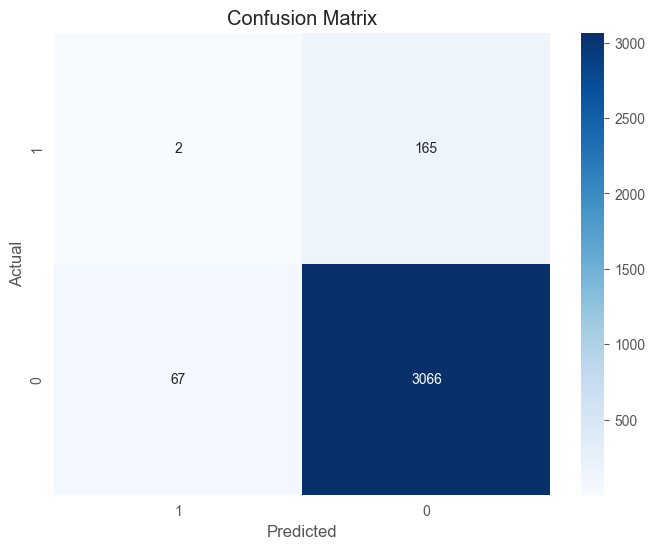

In [43]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred_labels,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

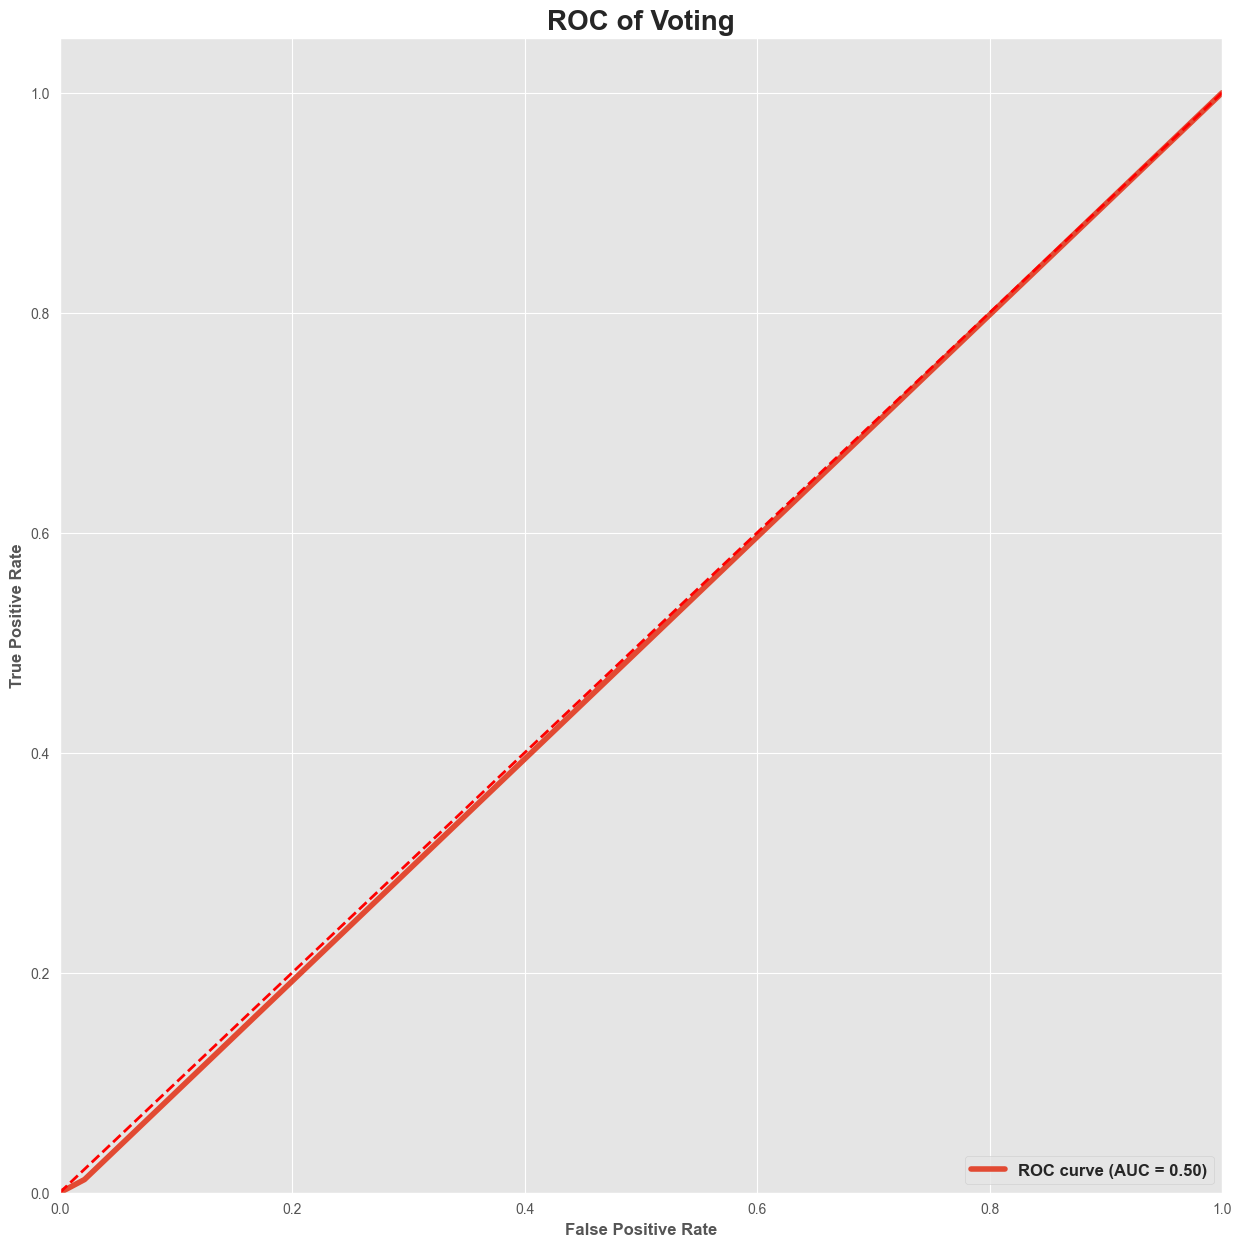

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, stacked_pred)

roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()

In [45]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [46]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    stacked_pred_labels = y_predict.argmax(axis=1)

    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(stacked_pred_labels[indx]))
    print("----------------------------")
    if Y_check==check_result(stacked_pred_labels[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1


104/104 [==============================] - 0s 2ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
